In [2]:
pip install nltk wordcloud matplotlib networkx


Note: you may need to restart the kernel to use updated packages.


In [4]:
import json
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import networkx as nx
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# NLTK resources download
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('universal_tagset')


[nltk_data] Downloading package punkt to /Users/thomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/thomas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/thomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/thomas/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [6]:
def clean_text(text):
    """
    Clean and lemmatize a single text string using NLTK:
      - Lowercase
      - Remove non-alphanumeric
      - Remove digits
      - Tokenize
      - POS-tag with universal tagset
      - Lemmatize based on POS
      - Remove stopwords
    """
    # Inlined imports to avoid re-importing each call
    import re
    from nltk import pos_tag, word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    
    # Initialize once (could also do globally)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Map universal POS tags to WordNet POS tags
    def map_pos(tag):
        if tag == 'ADV':
            return 'r'  # adverb
        elif tag == 'ADJ':
            return 'a'  # adjective
        elif tag == 'VERB':
            return 'v'  # verb
        else:
            return 'n'  # default to noun

    # Basic cleanup
    text = text.lower()
    text = re.sub(r'<.?>', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\W+', ' ', text)  # keep only words
    
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens, tagset='universal')
    
    cleaned_tokens = []
    for (word, t) in tagged:
        if word not in stop_words:
            wn_pos = map_pos(t)
            lemma = lemmatizer.lemmatize(word, pos=wn_pos)
            cleaned_tokens.append(lemma)
    
    return ' '.join(cleaned_tokens)


In [ ]:
data_path = "/Users/thomas/arxiv-metadata-oai-snapshot.json"  #  large JSONL file

category_counts = Counter()
category_abstracts = defaultdict(list)  # Map category -> list of raw abstracts
hep_ph_abstracts = []

G = nx.Graph()  # co-authorship graph

with open(data_path, 'r', encoding='utf-8') as f:
    for line in f:
        record = json.loads(line)
        
        # Categories
        cat_field = record.get('categories', '')
        cats = cat_field.split()  # Each record might have multiple categories
        for c in cats:
            category_counts[c] += 1
            # We store the abstract text for each category
            # because we need to find top words later
            abstract_text = record.get('abstract', '')
            category_abstracts[c].append(abstract_text)
        
        # For the word cloud of a selected category
        if 'hep-ph' in cats:
            hep_ph_abstracts.append(record.get('abstract', ''))
        
        # Co-authorship: authors are comma-separated
        authors_line = record.get('authors', '')
        authors_list = [a.strip() for a in authors_line.split(',') if a.strip()]
        
        # Build edges for each pair of authors
        for i in range(len(authors_list)):
            for j in range(i + 1, len(authors_list)):
                G.add_edge(authors_list[i], authors_list[j])


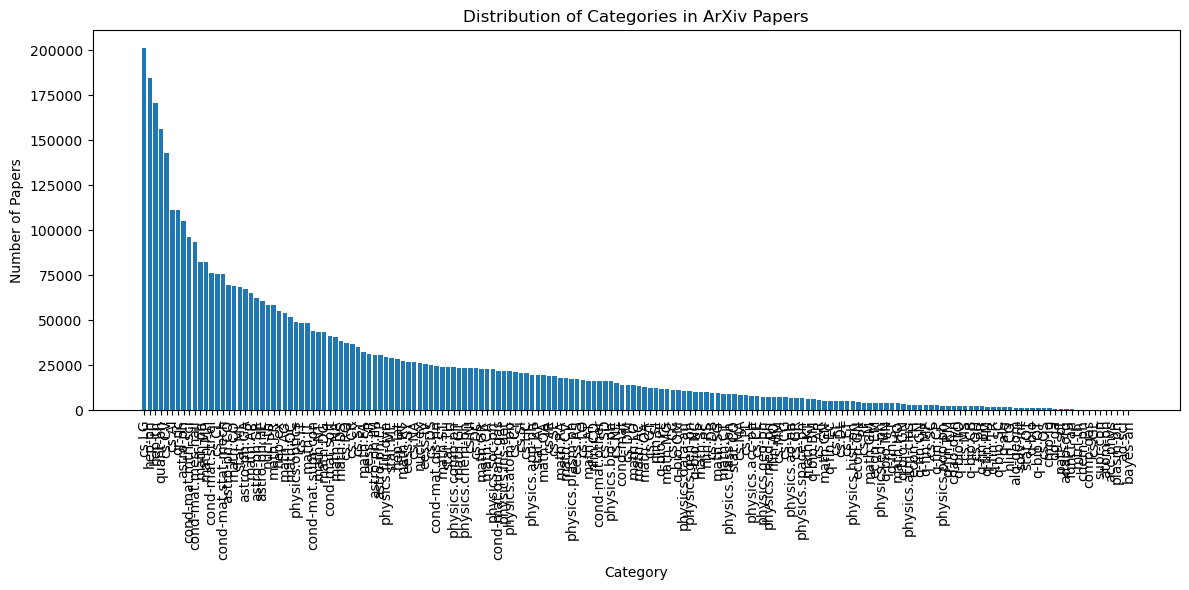

In [10]:
# Sort categories by frequency (descending)
sorted_categories = category_counts.most_common()
cats, freqs = zip(*sorted_categories)

plt.figure(figsize=(12, 6))
plt.bar(cats, freqs)
plt.title('Distribution of Categories in ArXiv Papers')
plt.xlabel('Category')
plt.ylabel('Number of Papers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


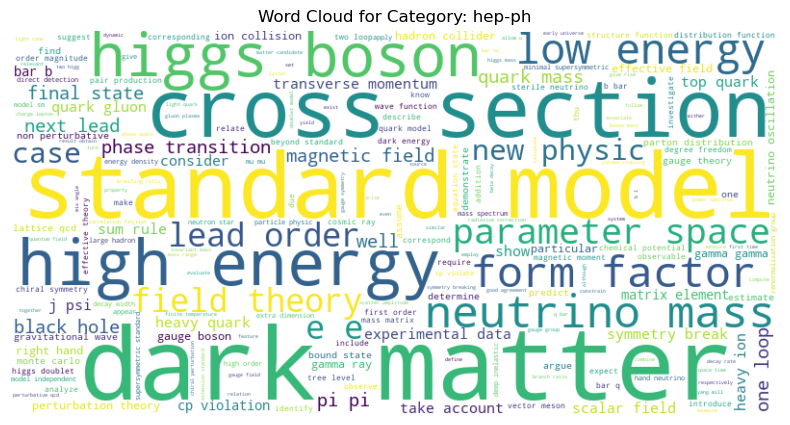

In [12]:
from wordcloud import WordCloud

# Clean each abstract and combine
cleaned_hep_ph_abstracts = [clean_text(ab) for ab in hep_ph_abstracts]
combined_hep_ph_text = ' '.join(cleaned_hep_ph_abstracts)

wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate(combined_hep_ph_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Category: hep-ph')
plt.show()

In [14]:
import nltk
from collections import Counter

top_5_categories = [cat for (cat, _) in category_counts.most_common(5)]
top_words = {}

for cat in top_5_categories:
    # Get raw abstracts
    raw_texts = category_abstracts[cat]
    # Clean them all
    cleaned_texts = [clean_text(t) for t in raw_texts]
    # Combine into one string
    combined = ' '.join(cleaned_texts)
    
    # Tokenize to count word frequency
    tokens = nltk.word_tokenize(combined)
    freq = Counter(tokens)
    
    # Get the top 3
    top_words[cat] = freq.most_common(3)

for category, word_list in top_words.items():
    print(f"Top 3 words for category '{category}':")
    for word, count in word_list:
        print(f"  {word}: {count}")

Top 3 words for category 'cs.LG':
  model: 367244
  data: 229301
  method: 199171
Top 3 words for category 'hep-ph':
  model: 173078
  mass: 124639
  energy: 85495
Top 3 words for category 'hep-th':
  theory: 178196
  field: 142618
  model: 120280
Top 3 words for category 'quant-ph':
  quantum: 354980
  state: 189747
  system: 124138
Top 3 words for category 'cs.CV':
  image: 258096
  model: 230583
  method: 190549


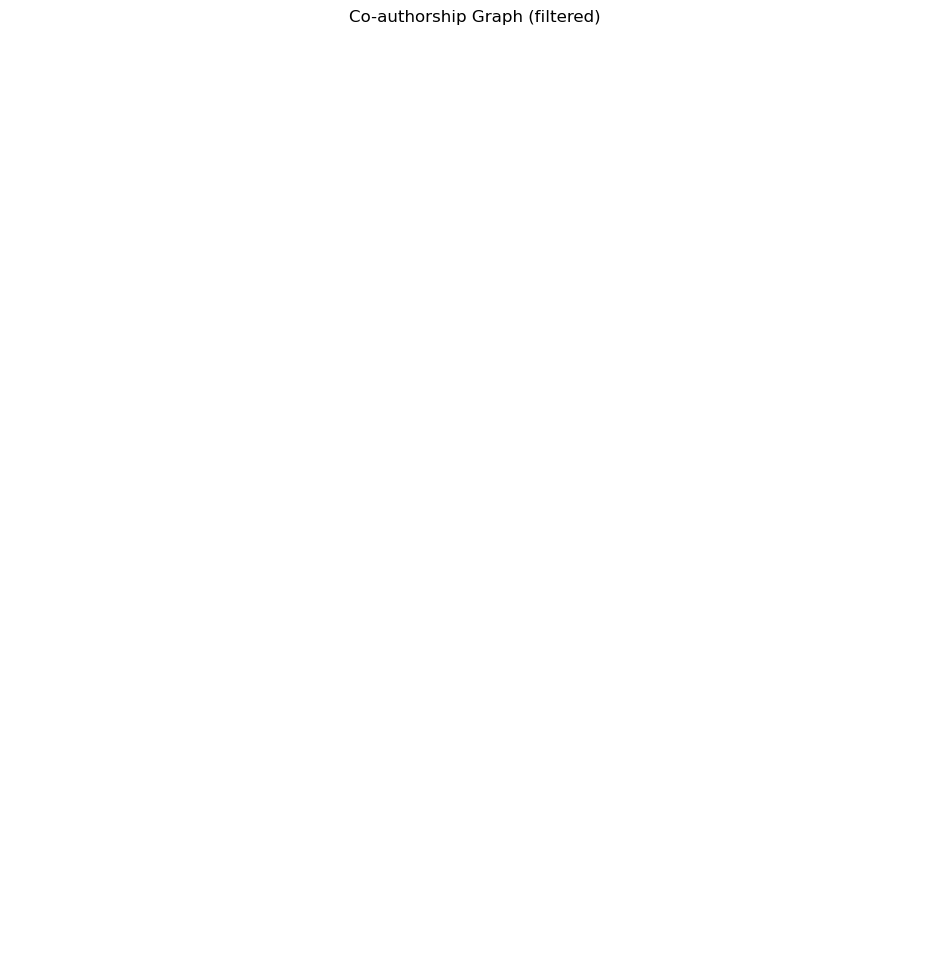

In [16]:
# attempt number 1 to complete the author's graph-> doesn't work too many nodes
import matplotlib.pyplot as plt
import networkx as nx

# Define or load your graph
G = nx.Graph()
# Example edges (replace with your actual logic to populate G)
G.add_node("Alice")
G.add_node("Bob")
G.add_edge("Alice", "Bob")

# For example, remove nodes with degree < 2
low_degree_nodes = [node for node, deg in G.degree() if deg < 2]
G.remove_nodes_from(low_degree_nodes)

# Now visualize with a spring layout
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.3)  # k controls spacing
nx.draw_networkx(
    G, 
    pos,
    with_labels=True,
    node_size=50,    
    font_size=8,
    edge_color="gray"
)

plt.title("Co-authorship Graph (filtered)")
plt.axis('off')
plt.show()


In [ ]:
#attempt 2 -> don't know if it works, too long to execute 
import json
import networkx as nx
import matplotlib.pyplot as plt

data_path = "/Users/thomas/arxiv-metadata-oai-snapshot.json"

# 2. Create an empty undirected graph
G = nx.Graph()

# 3. Read the file line by line and build edges based on co-authorship
with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        record = json.loads(line)
        
        # "authors_parsed" is a list of lists, e.g. [["Balázs","C.",""], ["Berger","E. L.",""], ...]
        # We'll combine each sub-list into a single author name.
        raw_authors = record.get("authors_parsed", [])
        
        # Convert sub-lists like ["Balázs", "C.", ""] -> "Balázs C."
        authors_list = []
        for sub in raw_authors:
            # Filter out empty strings, then join with a space
            name = " ".join(part for part in sub if part.strip())
            name = name.strip()
            if name:  # make sure it's not empty
                authors_list.append(name)
        
        # Now we have a list of author names for this paper
        # For each pair of authors, add an edge (co-authorship)
        for i in range(len(authors_list)):
            for j in range(i + 1, len(authors_list)):
                G.add_edge(authors_list[i], authors_list[j])

# 4. Optionally, filter out authors (nodes) with degree < 2
low_degree_nodes = [node for node, deg in G.degree() if deg < 2]
G.remove_nodes_from(low_degree_nodes)

# 5. Visualize the co-author graph
plt.figure(figsize=(12, 10))
# spring_layout tries to spread out nodes to minimize overlap
pos = nx.spring_layout(G, k=0.3)

nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    node_size=200,
    font_size=8,
    edge_color="gray"
)

plt.title("ArXiv Sample Co-Authorship Graph (Filtered)")
plt.axis('off')
plt.show()


In [ ]:
#See task 2 correctly managed in the other notebook: Assignment_4_Task_2